In [2]:
import sys
sys.path.append('../..')

import eeg_decoder
import numpy as np
from collections import OrderedDict
import pandas as pd
import ast
import mord
%load_ext autoreload
%autoreload 2

In [3]:
experiment_name = 'e'
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1500])

In [4]:
bad = []
for isub in range(exp.nsub):
    try:
        beh = exp.load_behavior(isub)
    except:
        bad.append(isub)

In [5]:
time_window = 25 
time_step = 25
trial_bin_size = 5
n_splits = 10
group_dict = OrderedDict([('M1_0C',[0]),('M1_1C',[1]), ('M2_0C', [2]), ('M2_1C', [3]), ('M2_2C',[4]),('C1_0C',[5]),('C1_1C',[6]), ('C2_0C', [7]), ('C2_1C', [8]), ('C2_2C',[9])])
training_labels = ['M2_0C','M2_1C','M2_2C']
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict,train_labels=training_labels)
clfr = eeg_decoder.Classification(wrangl,exp.nsub, num_labels=10)

In [6]:
def format_coh(row): return ast.literal_eval(row.replace(', ',',').replace(' ',','))
def get_coherences(df):
    
    coherences = df['Coherences'].apply(format_coh)
    coh_1 = coherences.apply(lambda row: row[0]).values
    coh_2 = coherences.apply(lambda row: row[1]).values
    return coh_1, coh_2

In [7]:
def create_new_label(row):
    if row['BlockFeature']== 0:
        feat = 'C'
    else:
        feat = 'M'
    if row['SetSize']==1:
        return f'{feat}1_{row["coh1"]}C'
    else:
        return f'{feat}2_{row["coh1"]+row["coh2"]}C'

In [8]:
def prep_data(xdata,beh):
    # remove ss0 and attend color
    remove_ss0 = (beh.SetSize!=0).astype(bool)
    xdata, beh = xdata[remove_ss0], beh.query('SetSize!=0').reset_index(drop=True)

    # get coherences for memory items
    coh1, coh2 = get_coherences(beh)
    beh.loc[:,'coh1'], beh.loc[:,'coh2'] = coh1, coh2

    # get labels
    beh['labels'] = beh.apply(create_new_label,axis=1)
    label_remap = {'M1_0C':0, 'M1_1C':1, 'M2_0C': 2, 'M2_1C': 3, 'M2_2C':4,'C1_0C':5,'C1_1C':6, 'C2_0C': 7, 'C2_1C': 8, 'C2_2C':9}
    beh['labels_remap'] = beh['labels'].map(label_remap)
    return xdata, beh.labels_remap.values 

In [11]:
from sklearn.metrics import confusion_matrix
def decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub):
    itime = wrangl.itime
    ifold = wrangl.ifold

    X_train, X_test = clfr.standardize(X_train, X_test)

    clfr.classifier.fit(X_train, y_train)

    clfr.acc[isub, itime, ifold] = clfr.classifier.score(X_test, y_test)
    clfr.acc_shuff[isub, itime, ifold] = clfr.classifier.score(X_test, y_test_shuffle)

    clfr.conf_mat[isub, itime, ifold] = confusion_matrix(
        y_test, y_pred=clfr.classifier.predict(X_test)
    )

    confidence_scores = clfr.classifier.decision_function(X_test)
    for i, ss in enumerate(set(y_test)):
        clfr.confidence_scores[isub, itime, ifold, i] = np.mean(confidence_scores[y_test == ss])

In [12]:
for isub in range(exp.nsub):
    print(isub)

    xdata,_ = exp.load_eeg(isub)
    beh = pd.DataFrame(exp.load_behavior(isub))
    
    xdata,ydata = prep_data(xdata,beh)
    train_idx = np.isin(ydata,[2,3,4])
    xdata_train, ydata_train = xdata[train_idx], ydata[train_idx]
    xdata_test, ydata_test = xdata[~train_idx], ydata[~train_idx]
    xdata_test, ydata_test = wrangl.bin_trials(xdata_test,ydata_test)

    for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata_train,ydata_train):

        X_test_all,y_test = np.concatenate((X_test_all,xdata_test)),np.concatenate((y_test,ydata_test),0)
        X_train_all, X_test_all, y_train, y_test = wrangl.balance_data(X_train_all, X_test_all, y_train, y_test)

        y_test_shuffle = np.random.permutation(y_test)

        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
            decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)
interp_motion = eeg_decoder.Interpreter(clfr, subtitle='coh_attend_motion') 
# interp_motion.save_results(timestamp=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [14]:
clfr.confidence_scores.shape

(15, 70, 10, 10)

In [15]:
conf_mean = np.mean(np.mean(clfr.confidence_scores,2)[:,(wrangl.t>0)&(wrangl.t<500)],1)
conf_mean.shape

(15, 10)

In [16]:
from sklearn.metrics import pairwise_distances
pairwise_dist_heldout = np.empty((exp.nsub,10,10))
for i in range(exp.nsub):
    
    sub_heldout_idx = np.setdiff1d(np.arange(exp.nsub),0)
    conf_heldout = np.mean(conf_mean[sub_heldout_idx],0)
    conf_heldout = conf_mean[i]
    pairwise_dist_heldout[i] = pairwise_distances(conf_heldout)

ValueError: Expected 2D array, got 1D array instead:
array=[ 1.71236482e-16  5.78020876e-17  5.40793160e-17  2.42740131e-16
  8.21763292e-17  8.10914387e-17  7.87949952e-17 -6.25051157e-18
 -7.72640329e-17  7.30951895e-17].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [17]:
import matplotlib.pyplot as plt
plt.imshow(pairwise_distances(np.mean(conf_mean,0)))
plt.xticks(ticks=np.arange(10),labels=list(group_dict.keys()),rotation=45);
plt.yticks(ticks=np.arange(10),labels=list(group_dict.keys()));
plt.colorbar()

ValueError: Expected 2D array, got 1D array instead:
array=[5.24547337e-17 7.07052178e-17 4.62921515e-17 5.00820175e-17
 6.52386361e-17 4.39990123e-17 4.34896093e-17 4.84331123e-17
 1.20387056e-17 8.61147940e-17].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

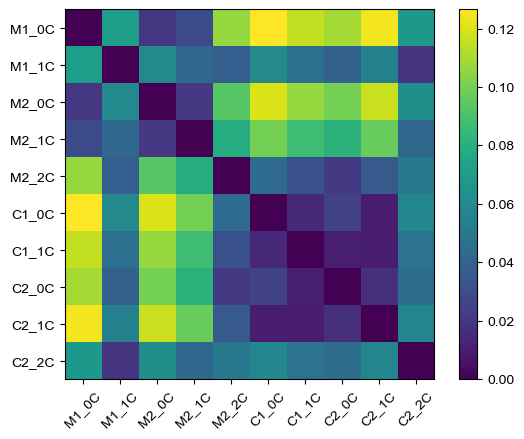

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(pairwise_distances(np.mean(conf_mean,0)))
plt.xticks(ticks=np.arange(10),labels=list(group_dict.keys()),rotation=45);
plt.yticks(ticks=np.arange(10),labels=list(group_dict.keys()));
plt.colorbar()

In [60]:
from sklearn.metrics import pairwise_distances

pairwise_distances(x)

array([[0.        , 0.11442814, 0.23228937, 0.10410134, 0.15900448,
        0.17026119, 0.14312497, 0.06601285, 0.15465839, 0.15741337],
       [0.11442814, 0.        , 0.12392015, 0.01262712, 0.04911523,
        0.06083716, 0.04740004, 0.08610451, 0.05415228, 0.06441779],
       [0.23228937, 0.12392015, 0.        , 0.13083907, 0.07497031,
        0.06324059, 0.08984548, 0.18209261, 0.07796489, 0.0785426 ],
       [0.10410134, 0.01262712, 0.13083907, 0.        , 0.05601749,
        0.06766728, 0.04798629, 0.07348382, 0.05693639, 0.06509455],
       [0.15900448, 0.04911523, 0.07497031, 0.05601749, 0.        ,
        0.01174155, 0.0267526 , 0.11603379, 0.01934892, 0.03263261],
       [0.17026119, 0.06083716, 0.06324059, 0.06766728, 0.01174155,
        0.        , 0.03319442, 0.12545081, 0.0225079 , 0.033023  ],
       [0.14312497, 0.04740004, 0.08984548, 0.04798629, 0.0267526 ,
        0.03319442, 0.        , 0.09335677, 0.01201085, 0.01717858],
       [0.06601285, 0.08610451, 0.1820926

In [33]:
interp_motion = eeg_decoder.Interpreter(clfr, subtitle='coh_attend_motion') 

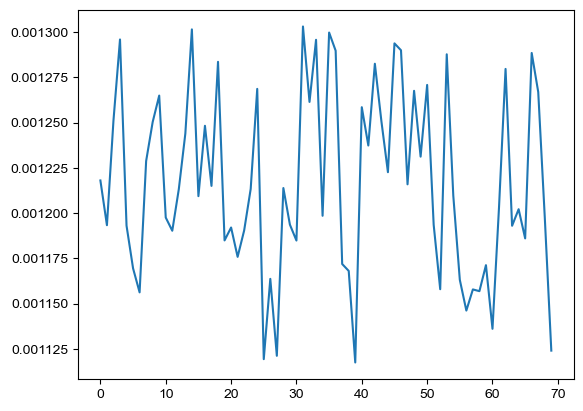

In [108]:
import matplotlib.pyplot as plt
plt.plot(np.mean(np.mean(interp_motion.acc_shuff,2),0))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


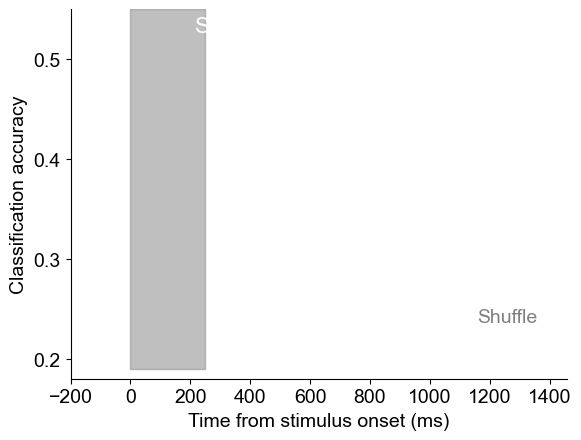

Mean delay accuracy: 0.0014497901489132854
Mean delay S.D.: 0.00010665434776586722


In [104]:
interp_motion.plot_acc()

IndexError: list index out of range

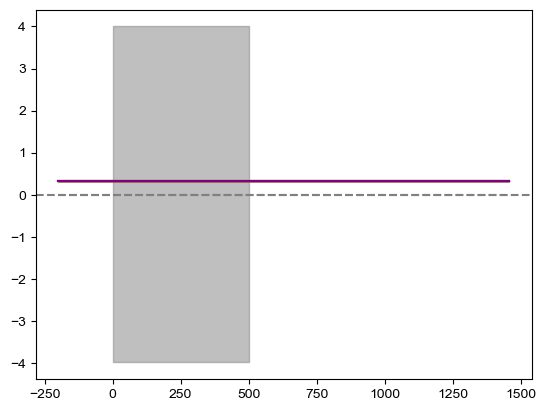

In [82]:
interp_motion.plot_hyperplane(
    subtitle='coh_hyperplane',
    stim_time=[0,500],
    label_text_ys=[-3,2.5],
    train_labels = ['SS1 0 Coh','SS1 1 Coh'],
    savefig=False
)